In [4]:
!ipc/ipc-static

ipc-static [-Bqsv] [-b buffersize] [-i pipe|local|tcp] [-p tcp_port]
	[-P l1d|l1i|l2|mem|tlb|axi] [-t totalsize] mode

Modes (pick one - default 1thread):
    1thread                IPC within a single thread
    2thread                IPC between two threads in one process
    2proc                  IPC between two threads in two different processes

Optional flags:
    -B                     Run in bare mode: no preparatory activities
    -i pipe|local|tcp      Select pipe, local sockets, or TCP (default: pipe)
    -p tcp_port            Set TCP port number (default: 10141)
    -P l1d|l1i|l2|mem|tlb|axi  Enable hardware performance counters
    -q                     Just run the benchmark, don't print stuff out
    -s                     Set send/receive socket-buffer sizes to buffersize
    -v                     Provide a verbose benchmark description
    -b buffersize          Specify a buffer size (default: 131072)
    -t totalsize           Specify total I/O size (default: 1677

In [5]:
!ipc/ipc-static -i pipe 2thread
!ipc/ipc-static -i local 2thread

274948.53 KBytes/sec
135210.06 KBytes/sec


In [6]:
!ipc/ipc-static -i local -s -b 1024 2thread

46141.98 KBytes/sec


In [7]:
!ipc/ipc-static -v -i pipe 2thread

Benchmark configuration:
  buffersize: 131072
  totalsize: 16777216
  blockcount: 128
  mode: 2thread
  ipctype: pipe
  time: 0.059394292
275851.42 KBytes/sec


In [8]:
!ipc/ipc-static -q -B -i pipe 2thread

In [14]:

setup_kernel()

kern.ipc.maxsockbuf: 33554432 -> 33554432


## Things to do
- [ ] instrument clock_gettime for the IPC loop
- [ ] it may be sensible to inspect quantize() results for both the execution time distributions of the system calls, and the amount of data returned by each
- [ ] investigate scheduling events using the sched provider ( on-cpu and off-cpu events)
- [ ] instrument sleep and wakeup
- [ ] take care about pid and tid
- [ ] probe effect: one simple way to approach the problem is to analyse the results of performance benchmarking with and without DTrace scripts running
- [ ] discard the first result
- [ ] read the FreeBSD Benchmarking Advice wiki
### questions to answer
- How does increasing IPC buffer size uniformly change performance across IPC models – and why?
- Explore the impact of the probe effect on your causal investigation; how has DTrace changed the behavior of the benchmark?


In [3]:
%matplotlib inline

from collections import defaultdict


def setup_kernel():
    !sysctl kern.ipc.maxsockbuf=33554432
# Callback invoked to print the trace record
# (that is, printf("%u", vtimestamp - self->start))

def benchmark(flags, trials, buff_sizes, dtrace_script,output_name="", quiet=False):
    values = []
    aggr_dict = defaultdict(int)

    def simple_out(value):
        values.append(value)
    
    def walk_func(a, b, c, d):
        pass
        #aggr_dict[c[0]] += d
    
    # print_header(["Starting io-static performance measurement",flags])

        # Create a seperate thread to run the DTrace instrumentation
    setup_kernel()
    dtrace_thread = DTraceConsumerThread(dtrace_script,
                                    chew_func=lambda v: None,
                                        chewrec_func=lambda v: None,
                                        out_func=simple_out,
                                        walk_func=walk_func,
                                        sleep=1)

    # Start the DTrace instrumentation
    dtrace_thread.start()

    # Display header to indicate that the benchmarking has started
    for size in buff_sizes:
        if not quiet:
            print("buffer size:", size, "collected so far: ",len(values))
        for i in range(trials):
            output = !ipc/ipc-static -B -q -b {str(size)} {flags} 2thread
            if len(output) > 0:
                print( "output:",output)
            
    # The benchmark has completed - stop the DTrace instrumentation
    dtrace_thread.stop()
    dtrace_thread.join()
    dtrace_thread.consumer.__del__()

    if not quiet:
        print("values collected:", len(values))

    if len(output_name) > 0:
        with open("lab2_{}_1202.data".format(output_name), 'w') as f:
            f.write(",".join([str(s) for s in BUFFER_SIZES]))
            f.write("\n")
            for value in values:
                f.write(value)
                f.write("\n")
                
    return values, aggr_dict

def plot_graph(input_data_file, title, label = "label",secondary = [], trials = 10,save = True, axis = None):
    # Plot the read performance (IO bandwidth against buffer size with error bars)
    with open(input_data_file, 'r') as f:
        content = f.readlines()

    # Buffer sizes to compute the performance with
    BUFFER_SIZES = [int(v) for v in content[0].split(',')]

    # Total size of iofile (default size) = 16MiB
    TOTAL_SIZE = BUFFER_SIZES[-1] #16*1024*1024
    read_performance_values =  [int(v.strip()) for v in content[1::2]]

    # Number of trials for each buffer size
    NUM_TRIALS = trials

    # Compute the IO bandwidth in KiBytes/sec
    io_bandwidth_values = [(TOTAL_SIZE/1024)/(val/1e9) for val in read_performance_values]
    io_bandwidth_avg = [sum(io_bandwidth_values[i*NUM_TRIALS:(i+1)*NUM_TRIALS])/NUM_TRIALS for i in range(len(BUFFER_SIZES))]

    # Reshape the list into an array of size [len(BUFFER_SIZES), NUM_TRIALS]
    io_bandwidth = np.reshape(io_bandwidth_values, (len(BUFFER_SIZES), NUM_TRIALS))[:,:]

    # Convert the array of io bandwidth values into a Panda DataFrame
    # this allows ploting of the median value and computation of the 
    # error bars (25 and 75 percentile values)
    # Note: The error bars should be small indicating that the experiment is tightly controlled
    df = pd.DataFrame(io_bandwidth, index=BUFFER_SIZES)
   

    # Compute error bars based on the 25 and 75 quartile values
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]

    # Create and label the plot

    if axis is None:
        fig = plt.figure(figsize=(20,7))
        ax = df.median(1).plot(yerr=error_bars_values, title=title, label = label)
    else:
        ax = df.median(1).plot(yerr=error_bars_values, title=title, ax=axis, label = label)


    
    plt.title(title)#'io-static {} performance'.format(label))
    plt.ylabel('IPC bandwidth (KiBytes/sec)')
    plt.xlabel('Buffer size (Bytes)')
    plt.xscale('log')
    plt.grid('on', axis='x' )
    plt.grid('on', axis='y' )

    plt.legend()
    # Plot a vertical line at 1MiB
    #plt.axvline(x=1024*1024, color='g')
    #  max_perf = np.argmax(np.array(io_bandwidth_avg))
    #plt.axvline(x=BUFFER_SIZES[max_perf], color='r')
    #print(max_perf,BUFFER_SIZES[max_perf])

    if save:
        plt.savefig("ipc_performance_{}.png".format(title.replace("/","").replace(" ","_")))
        
    return ax

In [21]:
# IO performance varying the buffer size
ipc_trace_script = """

BEGIN {
    in_benchmark = 0;
}

syscall::clock_gettime:return
/execname == "ipc-static" && !in_benchmark/
{
    in_benchmark = 1;
    self->cstart = vtimestamp;
   /* printf("tid: %d, pid: %d, return clock_gettime", tid, pid);*/

}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark/
{
    in_benchmark = 0;
    trace(vtimestamp - self->cstart);
    /*printf("tid: %d, pid: %d, time: %d", tid, pid, vtimestamp - self->cstart);*/
}

syscall::exit:entry
/execname == "ipc-static"/
{
}

END
{
    exit(0);
}
"""
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0, 15)]


do_2_threads:

create second thread
sender: clock_gettime at the beginning
receiver: clock_gettime at the end

In [18]:

benchmark(
    flags="-i pipe",
    output_name="pipe",
    trials=10,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=ipc_trace_script
)

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 13)
('buffer size:', 4096, 'collected so far: ', 38)
('buffer size:', 8192, 'collected so far: ', 49)
('buffer size:', 16384, 'collected so far: ', 73)
('buffer size:', 32768, 'collected so far: ', 85)
('buffer size:', 65536, 'collected so far: ', 113)
('buffer size:', 131072, 'collected so far: ', 129)
('buffer size:', 262144, 'collected so far: ', 155)
('buffer size:', 524288, 'collected so far: ', 177)
('buffer size:', 1048576, 'collected so far: ', 197)
('buffer size:', 2097152, 'collected so far: ', 217)
('buffer size:', 4194304, 'collected so far: ', 235)
('buffer size:', 8388608, 'collected so far: ', 253)
('buffer size:', 16777216, 'collected so far: ', 271)
('values collected:', 299)


(['42717877575',
  '84299',
  '179327672',
  '87393',
  '154203049',
  '87902',
  '153664824',
  '90453',
  '147671383',
  '88452',
  '146903924',
  '85586',
  '159352322',
  '92196',
  '171652525',
  '88610',
  '152488994',
  '86881',
  '164793565',
  '87465',
  '112487008',
  '83757',
  '115896626',
  '80034',
  '124842732',
  '86247',
  '120103819',
  '87162',
  '113635824',
  '82335',
  '128642966',
  '92716',
  '124129071',
  '85519',
  '116379706',
  '88767',
  '124385066',
  '86222',
  '128619572',
  '90764',
  '102374983',
  '87159',
  '101953773',
  '88724',
  '102017244',
  '87164',
  '101614687',
  '91117',
  '99865466',
  '89329',
  '99154007',
  '86889',
  '101961355',
  '84168',
  '101921316',
  '81555',
  '101181400',
  '83825',
  '101969004',
  '80495',
  '105853902',
  '84654',
  '111507923',
  '78867',
  '107543709',
  '86709',
  '106200970',
  '81421',
  '104172219',
  '89269',
  '105434518',
  '82477',
  '106365112',
  '80657',
  '106253250',
  '87785',
  '108754023

In [27]:

benchmark(
    flags="-i local",
    output_name="local",
    trials=10,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=ipc_trace_script
)

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 18)
('buffer size:', 4096, 'collected so far: ', 38)
('buffer size:', 8192, 'collected so far: ', 56)
('buffer size:', 16384, 'collected so far: ', 77)
('buffer size:', 32768, 'collected so far: ', 89)
('buffer size:', 65536, 'collected so far: ', 111)
('buffer size:', 131072, 'collected so far: ', 132)
('buffer size:', 262144, 'collected so far: ', 151)
('buffer size:', 524288, 'collected so far: ', 177)
('buffer size:', 1048576, 'collected so far: ', 192)
('buffer size:', 2097152, 'collected so far: ', 217)
('buffer size:', 4194304, 'collected so far: ', 232)
('buffer size:', 8388608, 'collected so far: ', 254)
('buffer size:', 16777216, 'collected so far: ', 276)
('values collected:', 299)


(['63151690946',
  '80110',
  '235105409',
  '79705',
  '232551538',
  '85096',
  '236615981',
  '83084',
  '233151046',
  '83773',
  '237440170',
  '81214',
  '234755442',
  '82018',
  '233891949',
  '79280',
  '230624631',
  '81097',
  '232187784',
  '83367',
  '158809537',
  '82492',
  '157692776',
  '79126',
  '155307896',
  '85489',
  '156411070',
  '79863',
  '157597895',
  '85584',
  '156404857',
  '81870',
  '162620266',
  '82778',
  '158833696',
  '79129',
  '158975068',
  '80610',
  '160238986',
  '82742',
  '117740847',
  '89791',
  '117190291',
  '82700',
  '117430697',
  '82512',
  '118047212',
  '79475',
  '116915296',
  '83459',
  '117048460',
  '197475',
  '117130000',
  '83291',
  '117464097',
  '80357',
  '119869263',
  '80468',
  '117457582',
  '80066',
  '102931859',
  '81151',
  '103229659',
  '77258',
  '103540405',
  '104520',
  '102403244',
  '85745',
  '102870245',
  '82876',
  '102839923',
  '82111',
  '102602794',
  '80301',
  '103413263',
  '85161',
  '10374

In [28]:

benchmark(
    flags="-i local -s",
    output_name="socket_s",
    trials=10,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=ipc_trace_script
)

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 17)
('buffer size:', 4096, 'collected so far: ', 36)
('buffer size:', 8192, 'collected so far: ', 54)
('buffer size:', 16384, 'collected so far: ', 75)
('buffer size:', 32768, 'collected so far: ', 97)
('buffer size:', 65536, 'collected so far: ', 109)
('buffer size:', 131072, 'collected so far: ', 132)
('buffer size:', 262144, 'collected so far: ', 157)
('buffer size:', 524288, 'collected so far: ', 178)
('buffer size:', 1048576, 'collected so far: ', 198)
('buffer size:', 2097152, 'collected so far: ', 217)
('buffer size:', 4194304, 'collected so far: ', 236)
('buffer size:', 8388608, 'collected so far: ', 255)
('buffer size:', 16777216, 'collected so far: ', 278)
('values collected:', 299)


(['83546259876',
  '91361',
  '234577982',
  '87675',
  '233346552',
  '83197',
  '232116101',
  '88463',
  '233126408',
  '87965',
  '233642904',
  '84837',
  '233436355',
  '90749',
  '236125958',
  '172758',
  '232343202',
  '84237',
  '239518367',
  '83919',
  '159334203',
  '83885',
  '159098919',
  '74422',
  '161023344',
  '79664',
  '159589040',
  '81108',
  '159192147',
  '81691',
  '158477170',
  '81633',
  '158854277',
  '81382',
  '159380921',
  '83377',
  '159503143',
  '79904',
  '162725141',
  '83663',
  '120417289',
  '85980',
  '120028251',
  '81297',
  '120118602',
  '81089',
  '120441363',
  '81627',
  '120470568',
  '80786',
  '120730144',
  '85556',
  '120226495',
  '84876',
  '119692949',
  '77232',
  '122835238',
  '78923',
  '119877887',
  '85795',
  '104638108',
  '76742',
  '103067225',
  '84526',
  '103208362',
  '85517',
  '106871095',
  '83024',
  '102977983',
  '82850',
  '103512841',
  '80846',
  '103548129',
  '119416',
  '103764052',
  '84385',
  '10963

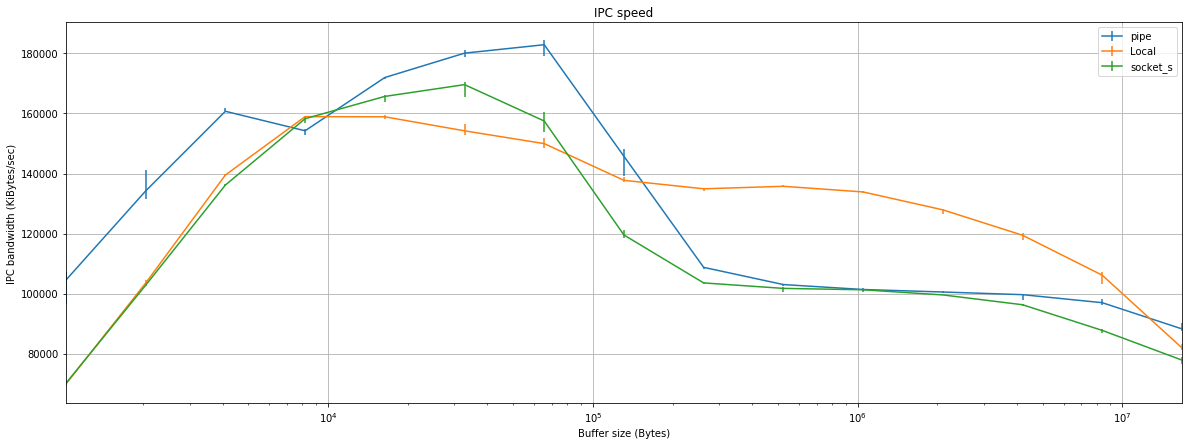

In [31]:
#def plot_graph(input_data_file, title, secondary = [], trials = 11,save = True):
ax = plot_graph(
    input_data_file="lab2_pipe_1202.data",
    label = "pipe",
    title="Pipe",
    save = False)
plot_graph(
    input_data_file="lab2_local_1202.data",
    label = "Local",
    title="",
    axis = ax,
    save = False)

plot_graph(
    input_data_file="lab2_socket_s_1202.data",
    label = "socket_s",
    title="IPC speed",
    axis = ax,
    save = False)


In [6]:
!ls

.ipynb_checkpoints      lab1_test_0702.data     lab2_local_1202.data    lab2_test_1202.data
ipc                     lab2.ipynb              lab2_socket_s_1202.data


In [33]:
# IO performance varying the buffer size
syscall_distribution = """

BEGIN {
    in_benchmark = 0
}

syscall::clock_gettime:return
/execname == "ipc-static" && !in_benchmark/
{
    in_benchmark = 1;
    self->cstart = vtimestamp;
   /* printf("tid: %d, pid: %d, return clock_gettime", tid, pid);*/

}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark/
{
    in_benchmark = 0;
  /*  printf("tid: %d, pid: %d, time: %d", tid, pid, vtimestamp - self->cstart);*/
}

syscall::read:return 
/execname == "ipc-static" && in_benchmark/
{
    @read = quantize(arg0)
}

syscall::write:return 
/execname == "ipc-static"  && in_benchmark/
{
    @write = quantize(arg0)
}

syscall::exit:entry
/execname == "ipc-static"/
{
    printf("Read aggregation:");
    printa(@read);
    printf("write aggregation:"); 
    printa(@write);
    
    clear(@read);
    clear(@write);

    printf("##################################"); 
}

END
{
    printf("hello world");
    exit(0);
}
"""
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
out, dic = benchmark(
    flags="-i pipe",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('buffer size:', 4096, 'collected so far: ', 0)
('buffer size:', 8192, 'collected so far: ', 14)
('buffer size:', 16384, 'collected so far: ', 14)
('buffer size:', 32768, 'collected so far: ', 14)
('buffer size:', 65536, 'collected so far: ', 14)
('buffer size:', 131072, 'collected so far: ', 14)
('buffer size:', 262144, 'collected so far: ', 14)
('buffer size:', 524288, 'collected so far: ', 56)
('buffer size:', 1048576, 'collected so far: ', 56)
('buffer size:', 2097152, 'collected so far: ', 56)
('buffer size:', 4194304, 'collected so far: ', 77)
('buffer size:', 8388608, 'collected so far: ', 77)
('buffer size:', 16777216, 'collected so far: ', 77)
('values collected:', 105)
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
            1024 |@@@@@@@@@@@

In [4]:
out, dic = benchmark(
    flags="-i local",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('buffer size:', 4096, 'collected so far: ', 0)
('buffer size:', 8192, 'collected so far: ', 14)
('buffer size:', 16384, 'collected so far: ', 14)
('buffer size:', 32768, 'collected so far: ', 14)
('buffer size:', 65536, 'collected so far: ', 14)
('buffer size:', 131072, 'collected so far: ', 42)
('buffer size:', 262144, 'collected so far: ', 42)
('buffer size:', 524288, 'collected so far: ', 42)
('buffer size:', 1048576, 'collected so far: ', 42)
('buffer size:', 2097152, 'collected so far: ', 70)
('buffer size:', 4194304, 'collected so far: ', 70)
('buffer size:', 8388608, 'collected so far: ', 70)
('buffer size:', 16777216, 'collected so far: ', 91)
('values collected:', 105)
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
            1024 |@@@@@@@@@@@

In [35]:
out, dic = benchmark(
    flags="-i local -s",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('buffer size:', 4096, 'collected so far: ', 0)
('buffer size:', 8192, 'collected so far: ', 14)
('buffer size:', 16384, 'collected so far: ', 14)
('buffer size:', 32768, 'collected so far: ', 14)
('buffer size:', 65536, 'collected so far: ', 14)
('buffer size:', 131072, 'collected so far: ', 42)
('buffer size:', 262144, 'collected so far: ', 42)
('buffer size:', 524288, 'collected so far: ', 42)
('buffer size:', 1048576, 'collected so far: ', 63)
('buffer size:', 2097152, 'collected so far: ', 63)
('buffer size:', 4194304, 'collected so far: ', 63)
('buffer size:', 8388608, 'collected so far: ', 84)
('buffer size:', 16777216, 'collected so far: ', 84)
('values collected:', 105)
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
            1024 |@@@@@@@@@@@

In [34]:
out, dic = benchmark(
    flags="-i local -s",
    trials=1,
    buff_sizes=[BUFFER_SIZES[-1]],
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 16777216, 'collected so far: ', 0)
('values collected:', 7)
Read aggregation:
value  ------------- Distribution ------------- count    
         8388608 |                                         0        
        16777216 |@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 1        
        33554432 |                                         0

write aggregation:
value  ------------- Distribution ------------- count    
         8388608 |                                         0        
        16777216 |@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 1        
        33554432 |                                         0

##################################


## Buffer sizes
It seems that all the reads matches the buffer size of the write, and all the buffers are always power of 2

In [38]:
# Scheduler activation
scheduler_script = """

BEGIN {
    in_benchmark = 0
}

syscall::clock_gettime:return
/execname == "ipc-static" && !in_benchmark/
{
    in_benchmark = 1;
    self->cstart = vtimestamp;
   /* printf("tid: %d, pid: %d, return clock_gettime", tid, pid);*/

}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark/
{
    in_benchmark = 0;
  /*  printf("tid: %d, pid: %d, time: %d", tid, pid, vtimestamp - self->cstart);*/
}

syscall::read: 
/execname == "ipc-static" && in_benchmark/
{
}

syscall::write: 
/execname == "ipc-static"  && in_benchmark/
{
}

sched:::off-cpu
/execname == "ipc-static" && in_benchmark/
{
   /* printf("off-cpu tid: %d, pid: %d", tid, pid);*/
    self->off_cpu = vtimestamp;

}
sched:::on-cpu
/execname == "ipc-static" && in_benchmark/
{
    off_time = vtimestamp - self->off_cpu;
   /* printf("on-cpu tid: %d, pid: %d, delay: %d", tid, pid, off_time);*/
    @off_cpu_aggr = sum(off_time);
    @off_cpu_aggr_cnt = count();
}


sched:::sleep
/execname == "ipc-static" && in_benchmark/
{
    self->sleep_start = vtimestamp;
}

sched:::wakeup
/execname == "ipc-static" && in_benchmark && self->sleep_start/
{

    @sleep = sum(vtimestamp - self->sleep_start);
}

syscall::exit:entry
/execname == "ipc-static"/
{
   /* printa("Off_cpu time: %d",@off_cpu_aggr);
    printa("offcpu count: %d",@off_cpu_aggr_cnt);
    printa("sleeptime: %d ms ", @sleep);*/
    printa(@off_cpu_aggr);
    printa(@off_cpu_aggr_cnt);
    printa(@sleep);
}

"""



In [39]:
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
for sz in BUFFER_SIZES:
    out, dic = benchmark(
        flags="-i pipe",
        trials=1,
        buff_sizes=[sz],
        dtrace_script=scheduler_script
    )
    print '\n'.join(out)
    print '###################################'

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('values collected:', 6)
75278726

13517

30554985930

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 2048, 'collected so far: ', 0)
('values collected:', 6)
265831399

8051

45904281809

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 4096, 'collected so far: ', 0)
('values collected:', 6)
403682079

5131

442297336

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 8192, 'collected so far: ', 0)
('values collected:', 6)
516393292

4157

4550308876

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 16384, 'collected so far: ', 0)
('values collected:', 6)
630287816

2060

10403138566

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 32768, 'collected so far: ', 0)
('valu